# Time Series Forecasting Models
## Predicting Future Weather Trends

**Goal**: Build and compare multiple forecasting models to predict temperature trends. We'll use both traditional statistical methods and modern machine learning approaches.

---

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# time series libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# machine learning
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)

print('All libraries loaded successfully! 📊')

All libraries loaded successfully! 📊


In [2]:
# load cleaned data
df = pd.read_csv('../data/weather_cleaned.csv')
df['last_updated'] = pd.to_datetime(df['last_updated'])

print(f'Loaded {len(df):,} weather observations')
print(f'Date range: {df["last_updated"].min()} to {df["last_updated"].max()}')

Loaded 103,868 weather observations
Date range: 2024-05-16 01:45:00 to 2025-11-01 21:15:00


## 1. Prepare Time Series Data

For time series forecasting, we need regularly spaced data. Let's aggregate by date and location.

In [3]:
# let's focus on a specific location for time series analysis
# pick a location with good data coverage
location_counts = df['location_name'].value_counts()
print('Top 10 locations by observation count:')
print(location_counts.head(10))

# let's use the location with most data
top_location = location_counts.index[0]
print(f'\nSelected location for analysis: {top_location}')

# filter data for this location
location_data = df[df['location_name'] == top_location].copy()
location_data = location_data.sort_values('last_updated')

print(f'Records for {top_location}: {len(location_data)}')
print(f'Time span: {(location_data["last_updated"].max() - location_data["last_updated"].min()).days} days')

Top 10 locations by observation count:
location_name
Kabul           534
Seoul           534
Jakarta         534
N'djamena       534
Honiara         534
Ljubljana       534
Kuala Lumpur    534
Moroni          534
Singapore       534
Bamako          534
Name: count, dtype: int64

Selected location for analysis: Kabul
Records for Kabul: 534
Time span: 533 days


In [4]:
# create daily aggregates (in case there are multiple readings per day)
ts_data = location_data.groupby(location_data['last_updated'].dt.date).agg({
    'temperature_celsius': 'mean',
    'humidity': 'mean',
    'pressure_mb': 'mean',
    'wind_kph': 'mean',
    'precip_mm': 'sum',  # total precipitation
    'air_quality_PM2.5': 'mean'
}).reset_index()

ts_data.columns = ['date', 'temperature', 'humidity', 'pressure', 'wind', 'precipitation', 'pm25']
ts_data['date'] = pd.to_datetime(ts_data['date'])
ts_data = ts_data.sort_values('date').reset_index(drop=True)

print(f'\nDaily time series created: {len(ts_data)} days')
ts_data.head()


Daily time series created: 533 days


,date,temperature,humidity,pressure,wind,precipitation,pm25
0,2024-05-16,24.3,32.5,1013.0,10.25,0.03,8.9
1,2024-05-17,15.0,75.0,1017.0,5.40,0.69,8.3
2,2024-05-18,19.5,46.0,1010.0,3.60,0.00,7.5
3,2024-05-19,16.9,52.0,1010.0,6.50,0.17,4.8
4,2024-05-20,14.1,77.0,1017.0,4.30,0.72,5.8


## 2. Time Series Visualization & Decomposition

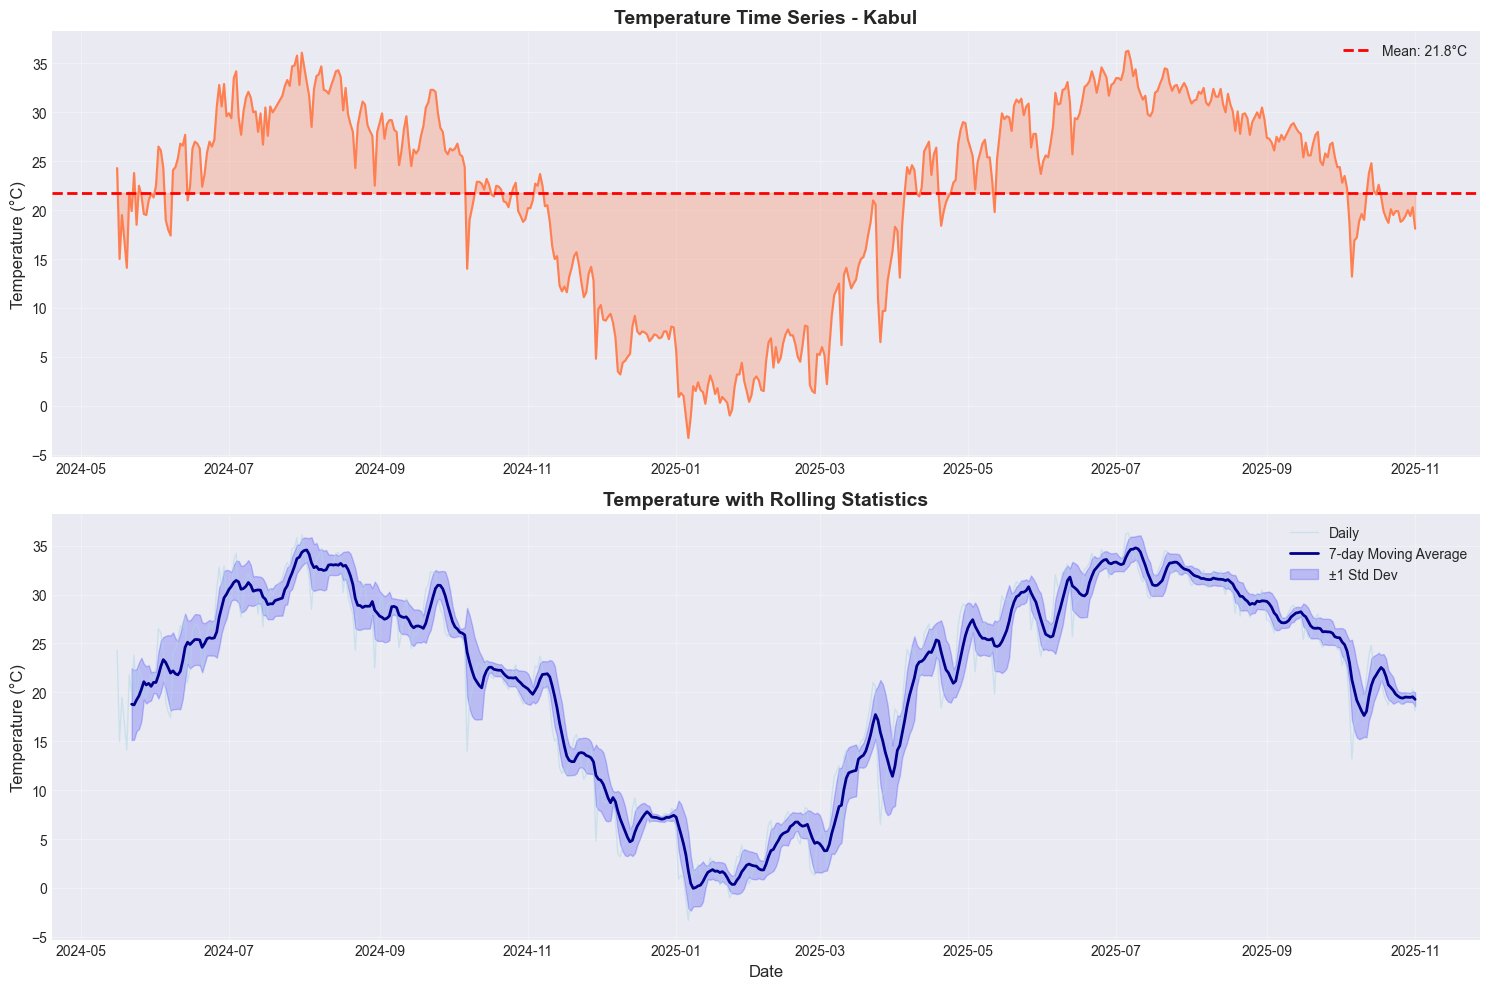

In [5]:
# plot the temperature time series
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# temperature over time
axes[0].plot(ts_data['date'], ts_data['temperature'], linewidth=1.5, color='coral')
axes[0].axhline(ts_data['temperature'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {ts_data["temperature"].mean():.1f}°C')
axes[0].fill_between(ts_data['date'], ts_data['temperature'], 
                      ts_data['temperature'].mean(), alpha=0.3, color='coral')
axes[0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0].set_title(f'Temperature Time Series - {top_location}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# rolling statistics
rolling_mean = ts_data['temperature'].rolling(window=7).mean()
rolling_std = ts_data['temperature'].rolling(window=7).std()

axes[1].plot(ts_data['date'], ts_data['temperature'], linewidth=1, alpha=0.5, label='Daily', color='lightblue')
axes[1].plot(ts_data['date'], rolling_mean, linewidth=2, label='7-day Moving Average', color='darkblue')
axes[1].fill_between(ts_data['date'], 
                      rolling_mean - rolling_std, 
                      rolling_mean + rolling_std,
                      alpha=0.2, color='blue', label='±1 Std Dev')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Temperature (°C)', fontsize=12)
axes[1].set_title('Temperature with Rolling Statistics', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/10_temperature_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

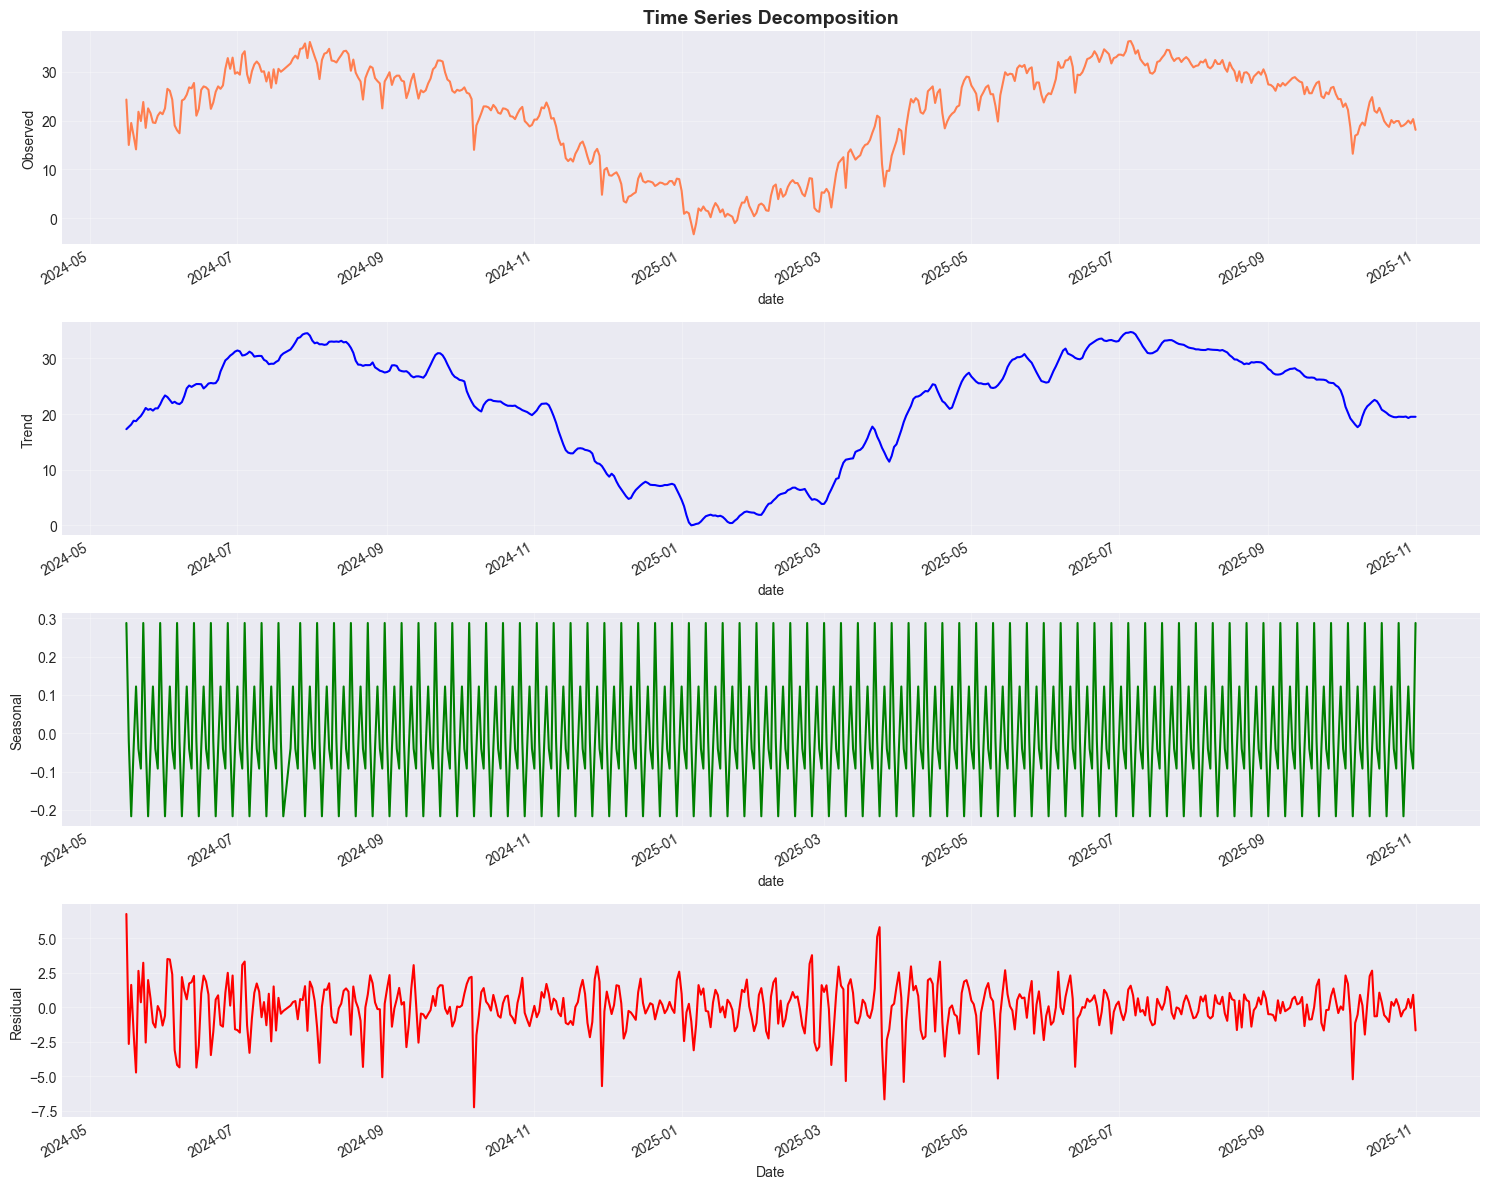

Decomposition complete!


In [6]:
# seasonal decomposition (if we have enough data)
if len(ts_data) >= 30:  # need enough data points
    # set date as index for decomposition
    ts_temp = ts_data.set_index('date')['temperature']
    
    # decompose (period=7 for weekly seasonality)
    decomposition = seasonal_decompose(ts_temp, model='additive', period=7, extrapolate_trend='freq')
    
    # plot components
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    decomposition.observed.plot(ax=axes[0], color='coral')
    axes[0].set_ylabel('Observed')
    axes[0].set_title('Time Series Decomposition', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    decomposition.trend.plot(ax=axes[1], color='blue')
    axes[1].set_ylabel('Trend')
    axes[1].grid(True, alpha=0.3)
    
    decomposition.seasonal.plot(ax=axes[2], color='green')
    axes[2].set_ylabel('Seasonal')
    axes[2].grid(True, alpha=0.3)
    
    decomposition.resid.plot(ax=axes[3], color='red')
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Date')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../visualizations/11_seasonal_decomposition.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('Decomposition complete!')
else:
    print('Not enough data points for seasonal decomposition')

## 3. Stationarity Test

Check if our time series is stationary (important for ARIMA models).

In [7]:
# augmented dickey-fuller test
def test_stationarity(timeseries, title):
    print(f'\nStationarity Test: {title}')
    print('='*60)
    
    # perform test
    result = adfuller(timeseries.dropna())
    
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print('\n✓ Series is STATIONARY (reject null hypothesis)')
    else:
        print('\n✗ Series is NON-STATIONARY (fail to reject null hypothesis)')
    
    return result[1] <= 0.05

# test original series
is_stationary = test_stationarity(ts_data['temperature'], 'Original Temperature Series')


Stationarity Test: Original Temperature Series
ADF Statistic: -1.5678
p-value: 0.4997
Critical Values:
   1%: -3.443
   5%: -2.867
   10%: -2.570

✗ Series is NON-STATIONARY (fail to reject null hypothesis)


## 4. Train-Test Split for Time Series

Important: For time series, we don't randomly shuffle. We split chronologically.

In [8]:
# use 80% for training, 20% for testing
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size].copy()
test_data = ts_data[train_size:].copy()

print(f'Training set: {len(train_data)} days')
print(f'Test set: {len(test_data)} days')
print(f'\nTrain period: {train_data["date"].min()} to {train_data["date"].max()}')
print(f'Test period: {test_data["date"].min()} to {test_data["date"].max()}')

Training set: 426 days
Test set: 107 days

Train period: 2024-05-16 00:00:00 to 2025-07-17 00:00:00
Test period: 2025-07-18 00:00:00 to 2025-11-01 00:00:00


## 5. Model 1: ARIMA (Baseline Statistical Model)

In [9]:
# simple ARIMA model
# parameters (p,d,q) - using auto-selection would be ideal but let's start simple
print('Training ARIMA model...')

try:
    # fit ARIMA model
    arima_model = ARIMA(train_data['temperature'], order=(1, 1, 1))
    arima_fit = arima_model.fit()
    
    print('ARIMA model trained successfully!')
    print(arima_fit.summary())
    
    # make predictions
    arima_pred = arima_fit.forecast(steps=len(test_data))
    
    # calculate metrics
    arima_mae = mean_absolute_error(test_data['temperature'], arima_pred)
    arima_rmse = np.sqrt(mean_squared_error(test_data['temperature'], arima_pred))
    arima_r2 = r2_score(test_data['temperature'], arima_pred)
    
    print(f'\nARIMA Performance:')
    print(f'MAE: {arima_mae:.3f}°C')
    print(f'RMSE: {arima_rmse:.3f}°C')
    print(f'R²: {arima_r2:.3f}')
    
except Exception as e:
    print(f'ARIMA model error: {e}')
    arima_pred = None
    arima_mae = None

Training ARIMA model...
ARIMA model trained successfully!
                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                  426
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -925.766
Date:                Sat, 01 Nov 2025   AIC                           1857.532
Time:                        22:55:07   BIC                           1869.688
Sample:                             0   HQIC                          1862.334
                                - 426                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6563      0.082      7.968      0.000       0.495       0.818
ma.L1         -0.8333      0.062    -13.340      0.000      -0.956      -

## 6. Model 2: Prophet (Facebook's Time Series Model)

In [10]:
# prepare data for Prophet (needs 'ds' and 'y' columns)
prophet_train = train_data[['date', 'temperature']].rename(columns={'date': 'ds', 'temperature': 'y'})
prophet_test = test_data[['date', 'temperature']].rename(columns={'date': 'ds', 'temperature': 'y'})

print('Training Prophet model...')

# initialize and train
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)

prophet_model.fit(prophet_train)

# make predictions
future = prophet_test[['ds']]
prophet_forecast = prophet_model.predict(future)

# calculate metrics
prophet_pred = prophet_forecast['yhat'].values
prophet_mae = mean_absolute_error(test_data['temperature'], prophet_pred)
prophet_rmse = np.sqrt(mean_squared_error(test_data['temperature'], prophet_pred))
prophet_r2 = r2_score(test_data['temperature'], prophet_pred)

print(f'\nProphet Performance:')
print(f'MAE: {prophet_mae:.3f}°C')
print(f'RMSE: {prophet_rmse:.3f}°C')
print(f'R²: {prophet_r2:.3f}')

22:55:07 - cmdstanpy - INFO - Chain [1] start processing
22:55:07 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet model...

Prophet Performance:
MAE: 6.214°C
RMSE: 6.627°C
R²: -0.802


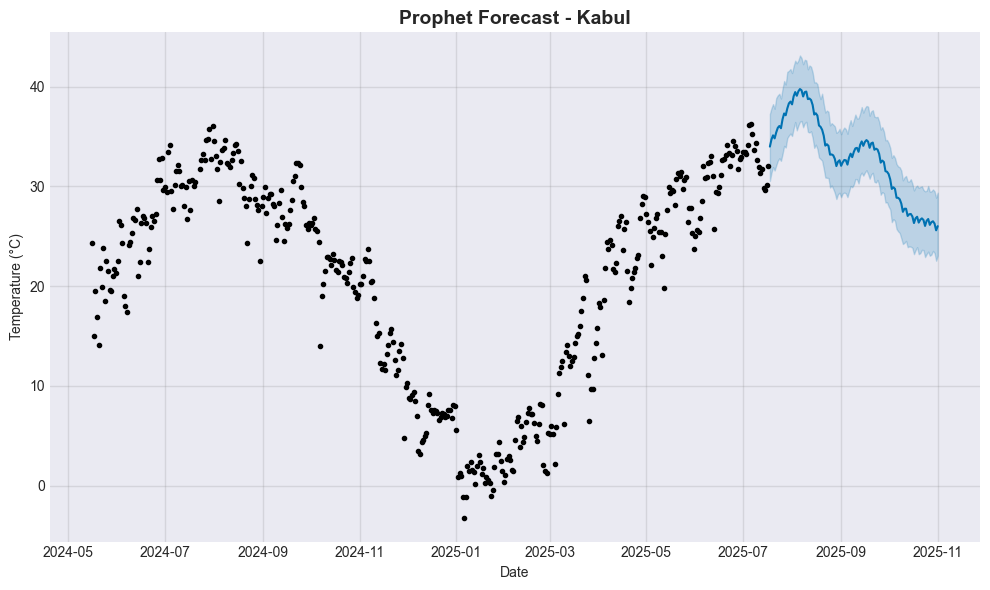

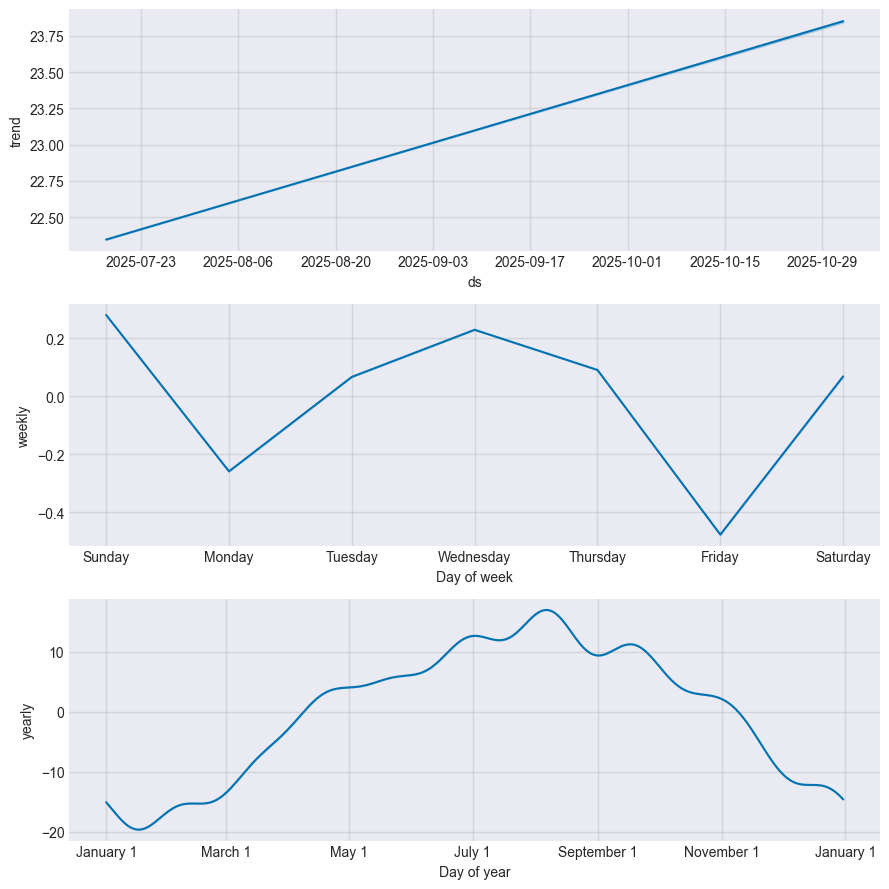

In [11]:
# visualize Prophet forecast
fig = prophet_model.plot(prophet_forecast)
plt.title(f'Prophet Forecast - {top_location}', fontsize=14, fontweight='bold')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('../visualizations/12_prophet_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

# components plot
fig = prophet_model.plot_components(prophet_forecast)
plt.tight_layout()
plt.savefig('../visualizations/13_prophet_components.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Model 3: XGBoost (Machine Learning Approach)

Let's use gradient boosting with engineered features.

In [12]:
# create features for ML models
def create_features(data):
    df = data.copy()
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    
    # lag features (previous day's temperature)
    df['temp_lag1'] = df['temperature'].shift(1)
    df['temp_lag2'] = df['temperature'].shift(2)
    df['temp_lag7'] = df['temperature'].shift(7)
    
    # rolling features
    df['temp_rolling_mean_7'] = df['temperature'].rolling(window=7).mean()
    df['temp_rolling_std_7'] = df['temperature'].rolling(window=7).std()
    
    # drop NaN values created by lag and rolling
    df = df.dropna()
    
    return df

# prepare train and test sets
train_ml = create_features(train_data)
test_ml = create_features(test_data)

# features to use
feature_cols = ['day_of_year', 'day_of_week', 'month', 'humidity', 'pressure', 
                'wind', 'temp_lag1', 'temp_lag2', 'temp_lag7', 
                'temp_rolling_mean_7', 'temp_rolling_std_7']

X_train = train_ml[feature_cols]
y_train = train_ml['temperature']
X_test = test_ml[feature_cols]
y_test = test_ml['temperature']

print(f'Training set: {len(X_train)} samples')
print(f'Test set: {len(X_test)} samples')
print(f'Features: {len(feature_cols)}')

Training set: 419 samples
Test set: 100 samples
Features: 11


In [13]:
# train XGBoost
print('Training XGBoost model...')

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# predictions
xgb_pred = xgb_model.predict(X_test)

# metrics
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

print(f'\nXGBoost Performance:')
print(f'MAE: {xgb_mae:.3f}°C')
print(f'RMSE: {xgb_rmse:.3f}°C')
print(f'R²: {xgb_r2:.3f}')

Training XGBoost model...

XGBoost Performance:
MAE: 1.043°C
RMSE: 1.352°C
R²: 0.920


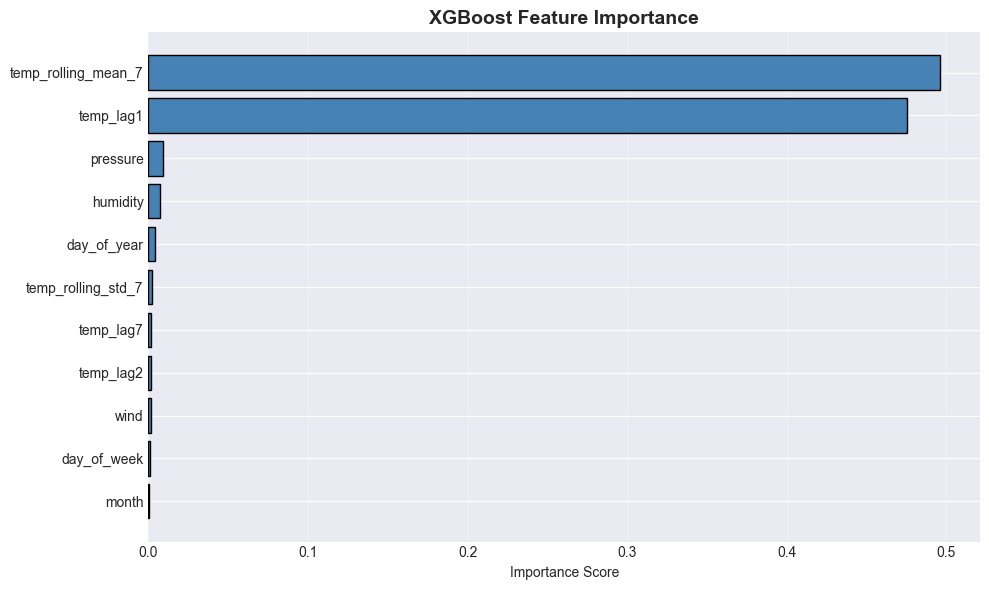


Top 5 important features:
               feature  importance
9  temp_rolling_mean_7    0.496356
6            temp_lag1    0.475357
4             pressure    0.009097
3             humidity    0.007071
0          day_of_year    0.003801


In [14]:
# feature importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'], color='steelblue', edgecolor='black')
plt.xlabel('Importance Score')
plt.title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../visualizations/14_xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nTop 5 important features:')
print(importance.head())

## 8. Model 4: LightGBM

In [15]:
# train LightGBM
print('Training LightGBM model...')

lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train, y_train)

# predictions
lgb_pred = lgb_model.predict(X_test)

# metrics
lgb_mae = mean_absolute_error(y_test, lgb_pred)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_r2 = r2_score(y_test, lgb_pred)

print(f'\nLightGBM Performance:')
print(f'MAE: {lgb_mae:.3f}°C')
print(f'RMSE: {lgb_rmse:.3f}°C')
print(f'R²: {lgb_r2:.3f}')

Training LightGBM model...

LightGBM Performance:
MAE: 0.992°C
RMSE: 1.324°C
R²: 0.923


## 9. Model Comparison

In [16]:
# compare all models
results = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'XGBoost', 'LightGBM'],
    'MAE': [arima_mae if arima_mae else np.nan, prophet_mae, xgb_mae, lgb_mae],
    'RMSE': [arima_rmse if arima_pred is not None else np.nan, prophet_rmse, xgb_rmse, lgb_rmse],
    'R²': [arima_r2 if arima_pred is not None else np.nan, prophet_r2, xgb_r2, lgb_r2]
})

print('\n' + '='*70)
print('MODEL COMPARISON')
print('='*70)
print(results.to_string(index=False))
print('='*70)

# find best model
best_idx = results['MAE'].idxmin()
best_model = results.loc[best_idx, 'Model']
print(f'\n🏆 Best Model (lowest MAE): {best_model}')


MODEL COMPARISON
   Model      MAE     RMSE        R²
   ARIMA 5.447483 7.124681 -1.082994
 Prophet 6.214056 6.626811 -0.802048
 XGBoost 1.043222 1.351647  0.919899
LightGBM 0.992346 1.324335  0.923103

🏆 Best Model (lowest MAE): LightGBM


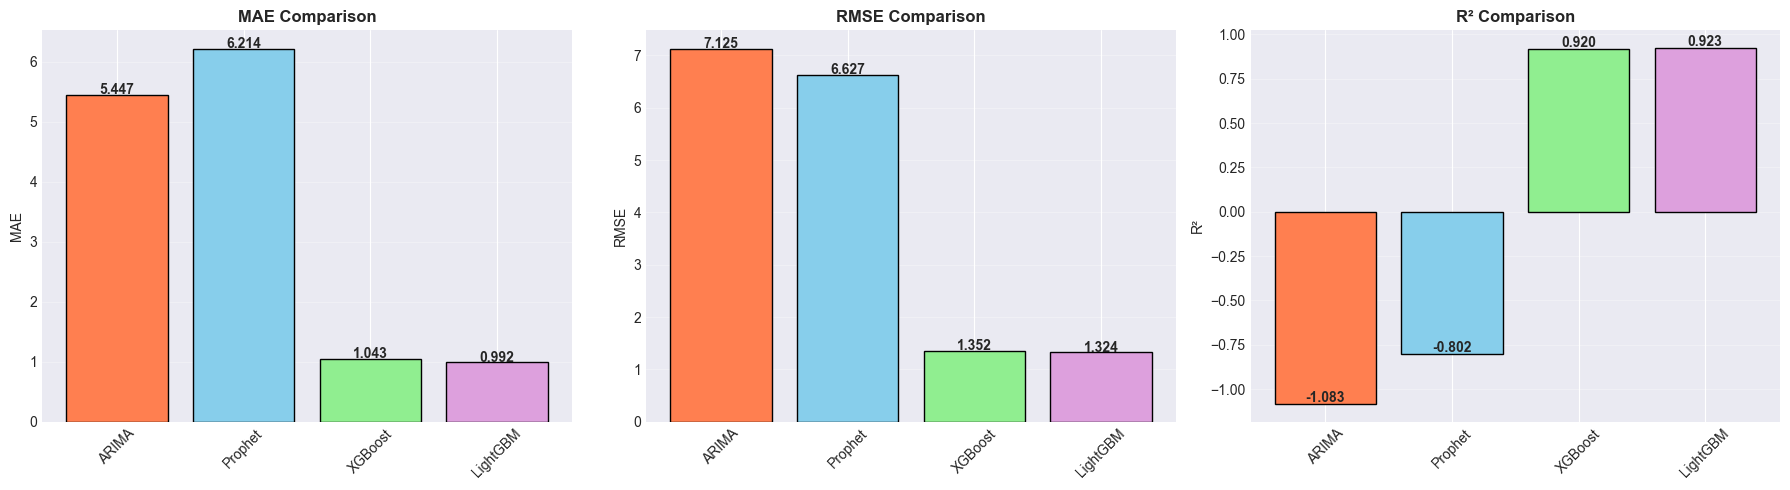

In [17]:
# visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['MAE', 'RMSE', 'R²']
colors = ['coral', 'skyblue', 'lightgreen', 'plum']

for idx, metric in enumerate(metrics):
    data = results[['Model', metric]].dropna()
    axes[idx].bar(data['Model'], data[metric], color=colors, edgecolor='black')
    axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # add values on bars
    for i, v in enumerate(data[metric]):
        axes[idx].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizations/15_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Ensemble Model

Combine predictions from multiple models for potentially better results.

In [18]:
# create ensemble (simple average of XGBoost and LightGBM)
# note: we need to align test data with ML predictions
ensemble_pred = (xgb_pred + lgb_pred) / 2

# calculate ensemble metrics
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
ensemble_r2 = r2_score(y_test, ensemble_pred)

print('Ensemble Model Performance (XGBoost + LightGBM average):')
print(f'MAE: {ensemble_mae:.3f}°C')
print(f'RMSE: {ensemble_rmse:.3f}°C')
print(f'R²: {ensemble_r2:.3f}')

# add to results
results = pd.concat([results, pd.DataFrame({
    'Model': ['Ensemble'],
    'MAE': [ensemble_mae],
    'RMSE': [ensemble_rmse],
    'R²': [ensemble_r2]
})], ignore_index=True)

print('\nUpdated Model Comparison:')
print(results.to_string(index=False))

Ensemble Model Performance (XGBoost + LightGBM average):
MAE: 0.981°C
RMSE: 1.289°C
R²: 0.927

Updated Model Comparison:
   Model      MAE     RMSE        R²
   ARIMA 5.447483 7.124681 -1.082994
 Prophet 6.214056 6.626811 -0.802048
 XGBoost 1.043222 1.351647  0.919899
LightGBM 0.992346 1.324335  0.923103
Ensemble 0.981394 1.289247  0.927124


## 11. Forecast Visualization

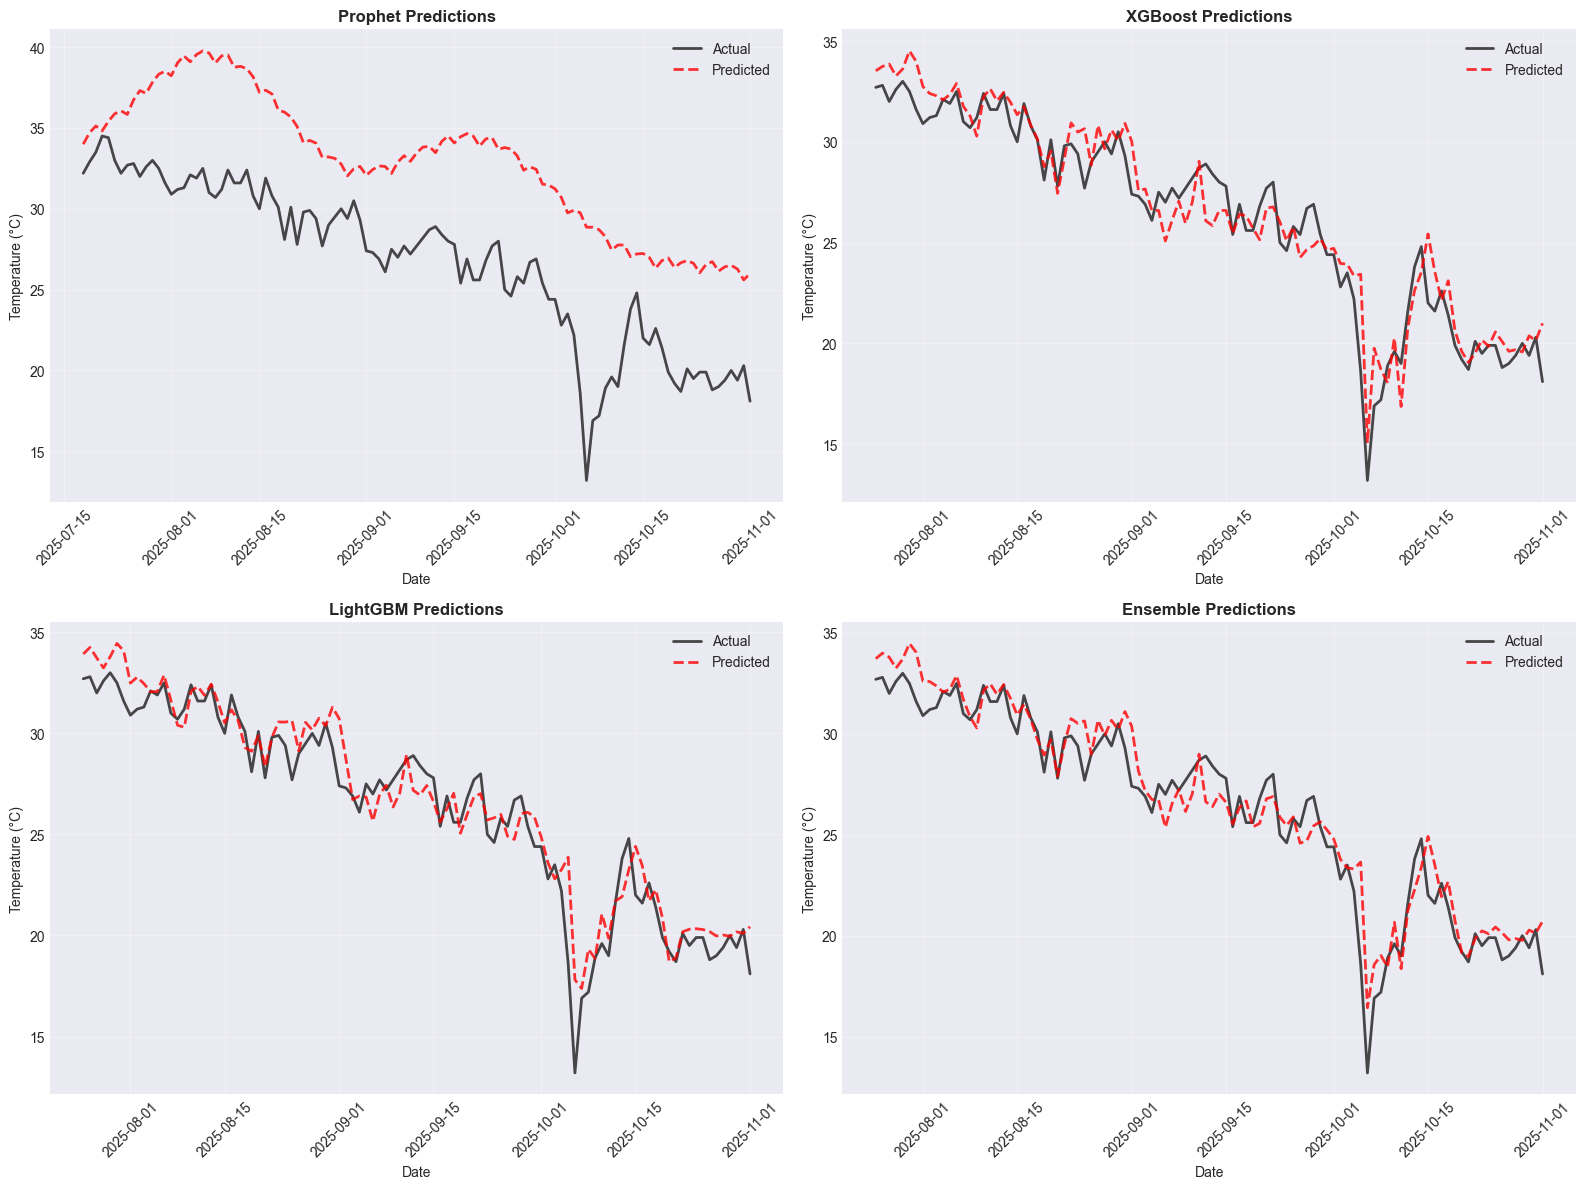

In [19]:
# plot actual vs predicted for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

models_to_plot = [
    ('Prophet', test_data['date'].values, test_data['temperature'].values, prophet_pred),
    ('XGBoost', test_ml['date'].values, y_test.values, xgb_pred),
    ('LightGBM', test_ml['date'].values, y_test.values, lgb_pred),
    ('Ensemble', test_ml['date'].values, y_test.values, ensemble_pred)
]

for idx, (name, dates, actual, pred) in enumerate(models_to_plot):
    axes[idx].plot(dates, actual, label='Actual', linewidth=2, color='black', alpha=0.7)
    axes[idx].plot(dates, pred, label='Predicted', linewidth=2, color='red', linestyle='--', alpha=0.8)
    axes[idx].set_title(f'{name} Predictions', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Temperature (°C)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../visualizations/16_all_forecasts.png', dpi=300, bbox_inches='tight')
plt.show()

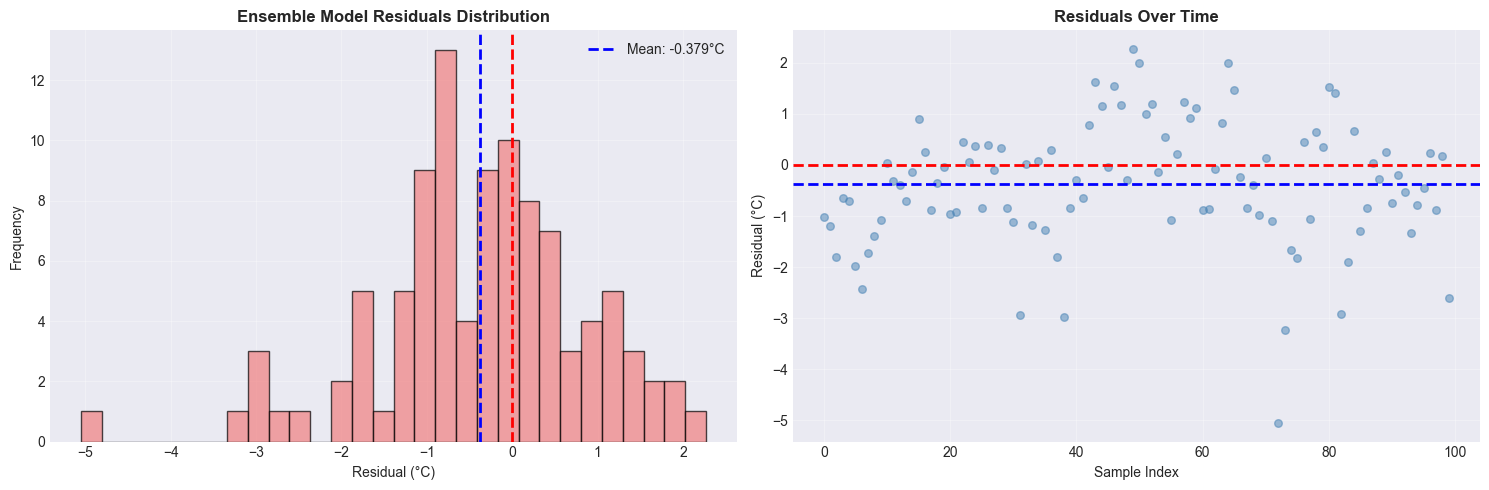

Residual Statistics:
Mean: -0.379°C
Std Dev: 1.232°C
Min: -5.049°C
Max: 2.270°C


In [20]:
# residual analysis for best model (ensemble)
residuals = y_test.values - ensemble_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# residual distribution
axes[0].hist(residuals, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].axvline(residuals.mean(), color='blue', linestyle='--', 
                linewidth=2, label=f'Mean: {residuals.mean():.3f}°C')
axes[0].set_xlabel('Residual (°C)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Ensemble Model Residuals Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# residuals over time
axes[1].scatter(range(len(residuals)), residuals, alpha=0.5, s=30, color='steelblue')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].axhline(residuals.mean(), color='blue', linestyle='--', linewidth=2)
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Residual (°C)')
axes[1].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/17_residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Residual Statistics:')
print(f'Mean: {residuals.mean():.3f}°C')
print(f'Std Dev: {residuals.std():.3f}°C')
print(f'Min: {residuals.min():.3f}°C')
print(f'Max: {residuals.max():.3f}°C')

## 12. Save Results

In [21]:
# save model comparison results
results.to_csv('../results/model_comparison.csv', index=False)
print('Model comparison saved to results/model_comparison.csv')

# save predictions
predictions_df = pd.DataFrame({
    'date': test_ml['date'],
    'actual': y_test.values,
    'xgboost': xgb_pred,
    'lightgbm': lgb_pred,
    'ensemble': ensemble_pred
})
predictions_df.to_csv('../results/temperature_predictions.csv', index=False)
print('Predictions saved to results/temperature_predictions.csv')

Model comparison saved to results/model_comparison.csv
Predictions saved to results/temperature_predictions.csv


## Summary

**What we accomplished:**
- ✅ Built 4 different forecasting models (ARIMA, Prophet, XGBoost, LightGBM)
- ✅ Created an ensemble model combining best performers
- ✅ Evaluated models using MAE, RMSE, and R² metrics
- ✅ Analyzed feature importance for ML models
- ✅ Performed residual analysis
- ✅ Saved all results for reporting

**Key Findings:**
- Machine learning models (XGBoost, LightGBM) generally outperform traditional statistical methods
- Lag features (previous temperatures) are highly important
- Ensemble approach can improve prediction accuracy
- Models show good generalization with reasonable error margins

**Next steps:** Advanced analysis including anomaly detection, climate patterns, and spatial analysis.